In [1]:
import simpledorff as sf
import pandas as pd
import json
import matplotlib.pyplot as plt
from simpledorff import data_transforms
from simpledorff.metrics import nominal_metric
from collections import Counter

plt.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (40, 13)
# Display Dataframes in full size
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Remove warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def create_dataframe(json_path, annotator_int):
    # load data using Python JSON module
    with open(json_path, 'r', encoding="utf-8") as f:
        data = json.loads(f.read())
    # Flatten data, keep entry ID and person who completed the data
    df_base_list = pd.json_normalize(
        data, record_path=['annotations', 'result'], meta=[
            'id',
            ['annotations', 'completed_by'],
            ['annotations', 'id'],
        ], record_prefix='_',
        errors='ignore'
                                      )

    # load original data separately
    with open(json_path, 'r', encoding="utf-8") as f:
        data = json.loads(f.read())
    # Flatten data, keep entry ID and person who completed the data
    df_original_data = pd.json_normalize(
        data, max_level=1, meta=['id'], record_prefix='_',
        errors='ignore'
                                      )

    # Only keep relevant columns from df_original_data
    series_id = df_original_data['id']
    series_data = df_original_data['data.text']
    df_original_data = pd.concat([series_id, series_data], axis=1)

    # Add original data to dataframe
    df_base_list = pd.merge(
        df_base_list, df_original_data,
        how='inner', left_on=['id'], right_on=['id'])

    # Only keep relevant columns from df_base_list
    series_datatype = df_base_list['_from_name']
    series_start = df_base_list['_value.start']
    series_end = df_base_list['_value.end']
    series_text = df_base_list['_value.text']
    series_label = df_base_list['_value.labels']
    series_speakerid = df_base_list['_meta.text']
    series_annotator = df_base_list['annotations.completed_by']
    series_id = df_base_list['annotations.id']
    series_original = df_base_list['data.text']
    df_base_list = pd.concat(
        [series_datatype, series_start, series_end, series_text, series_label,
            series_speakerid, series_annotator,
            series_id, series_original], axis=1)

    # Rename remaining columns
    df_base_list.columns = ['data_type', 'start', 'end', 'text', 'label',
                            'speaker_id', 'annotator', 'id', 'original_data']

    # Anonymise annotator by giving them a number
    df_base_list['annotator'] = annotator_int

    # Remove useless lists in labels and convert to string
    df_base_list['label'] = df_base_list['label'].str[0]
    df_base_list['label'] = df_base_list['label'].astype(str)

    # Separate speakers and speeches
    df_speakers = df_base_list[df_base_list['label'] == "Speaker"]
    df_speeches = df_base_list[df_base_list['label'] != "Speaker"]

    # Clean speakers dataframe by removing unused columns
    df_speakers = df_speakers.drop(['data_type', 'start', 'end', 'label',
                                    'annotator', 'id',
                                    'original_data'], axis=1)

    # Remove useless list in speaker_id
    df_speakers['speaker_id'] = df_speakers['speaker_id'].str[0]

    # Replace NaN values with -1 values, so we can convert the columns to int
    df_speeches['id'] = df_speeches['id'].fillna(-1)
    df_speakers['speaker_id'] = df_speakers['speaker_id'].fillna(-1)

    # Convert both columns to integer so we can merge later
    df_speeches['id'] = df_speeches['id'].astype(int)
    df_speakers['speaker_id'] = df_speakers['speaker_id'].astype(int)

    # Merge speakers and speeches dataframes based on matching IDs
    df_final = pd.merge(df_speeches, df_speakers, how='inner',
                        left_on=['id'], right_on=['speaker_id'])

    # Delete unused columns and rename new ones
    df_final = df_final.drop(['speaker_id_x', 'speaker_id_y'], axis=1)
    df_final.columns = ['data_type', 'start', 'end', 'text', 'label',
                        'annotator', 'id', 'original_data', 'speaker']

    # Remove speech lines and only keep those with emotions
    df_final = df_final[df_final['data_type'] == 'emotion']

    return df_final

In [3]:
def merge_dataframes(json_path_list):
    dataframes = []
    # Create the dataframes from json_path_list
    for idx, file in enumerate(json_path_list):
        df = create_dataframe(file, idx)
        dataframes.append(df)

    # Concatenate all dataframes into one
    df = pd.concat(dataframes)

    # Create rounded length of text to use as a margin of error when grouping
    df['rounded_length'] = (df['end'] - df['start']).round(-1)

    # Calculate Krippendorff's alpha
    kripp = sf.calculate_krippendorffs_alpha_for_df(
        df, experiment_col='rounded_length', annotator_col='annotator',
        class_col='label')
    print(kripp)

    # Shorten original_data so that the graphs are readable
    df_short = df
    df_short['original_data'] = df_short['original_data'].str.slice(0, 50)
    # Generate histograms grouped by paragraph, representing total of emotions
    graph = df_short.hist(column='label', by='original_data',
                          sharex=True, sharey=True)

    # Group rows by original_data and length of text
    df = df.groupby(['original_data', 'rounded_length'])

    return df, kripp, graph

In [4]:
def krippendorff_graph(list_values):
    series_graph = pd.Series(list_values)
    series_graph.plot()
    plt.show()

0.13510140405616222
0.14919852034525272
0.09013785790031814
0.4722222222222222
0.32815890502420286
0.291497975708502
0.1682926829268293
0.20194884287454318
0.16258351893095768


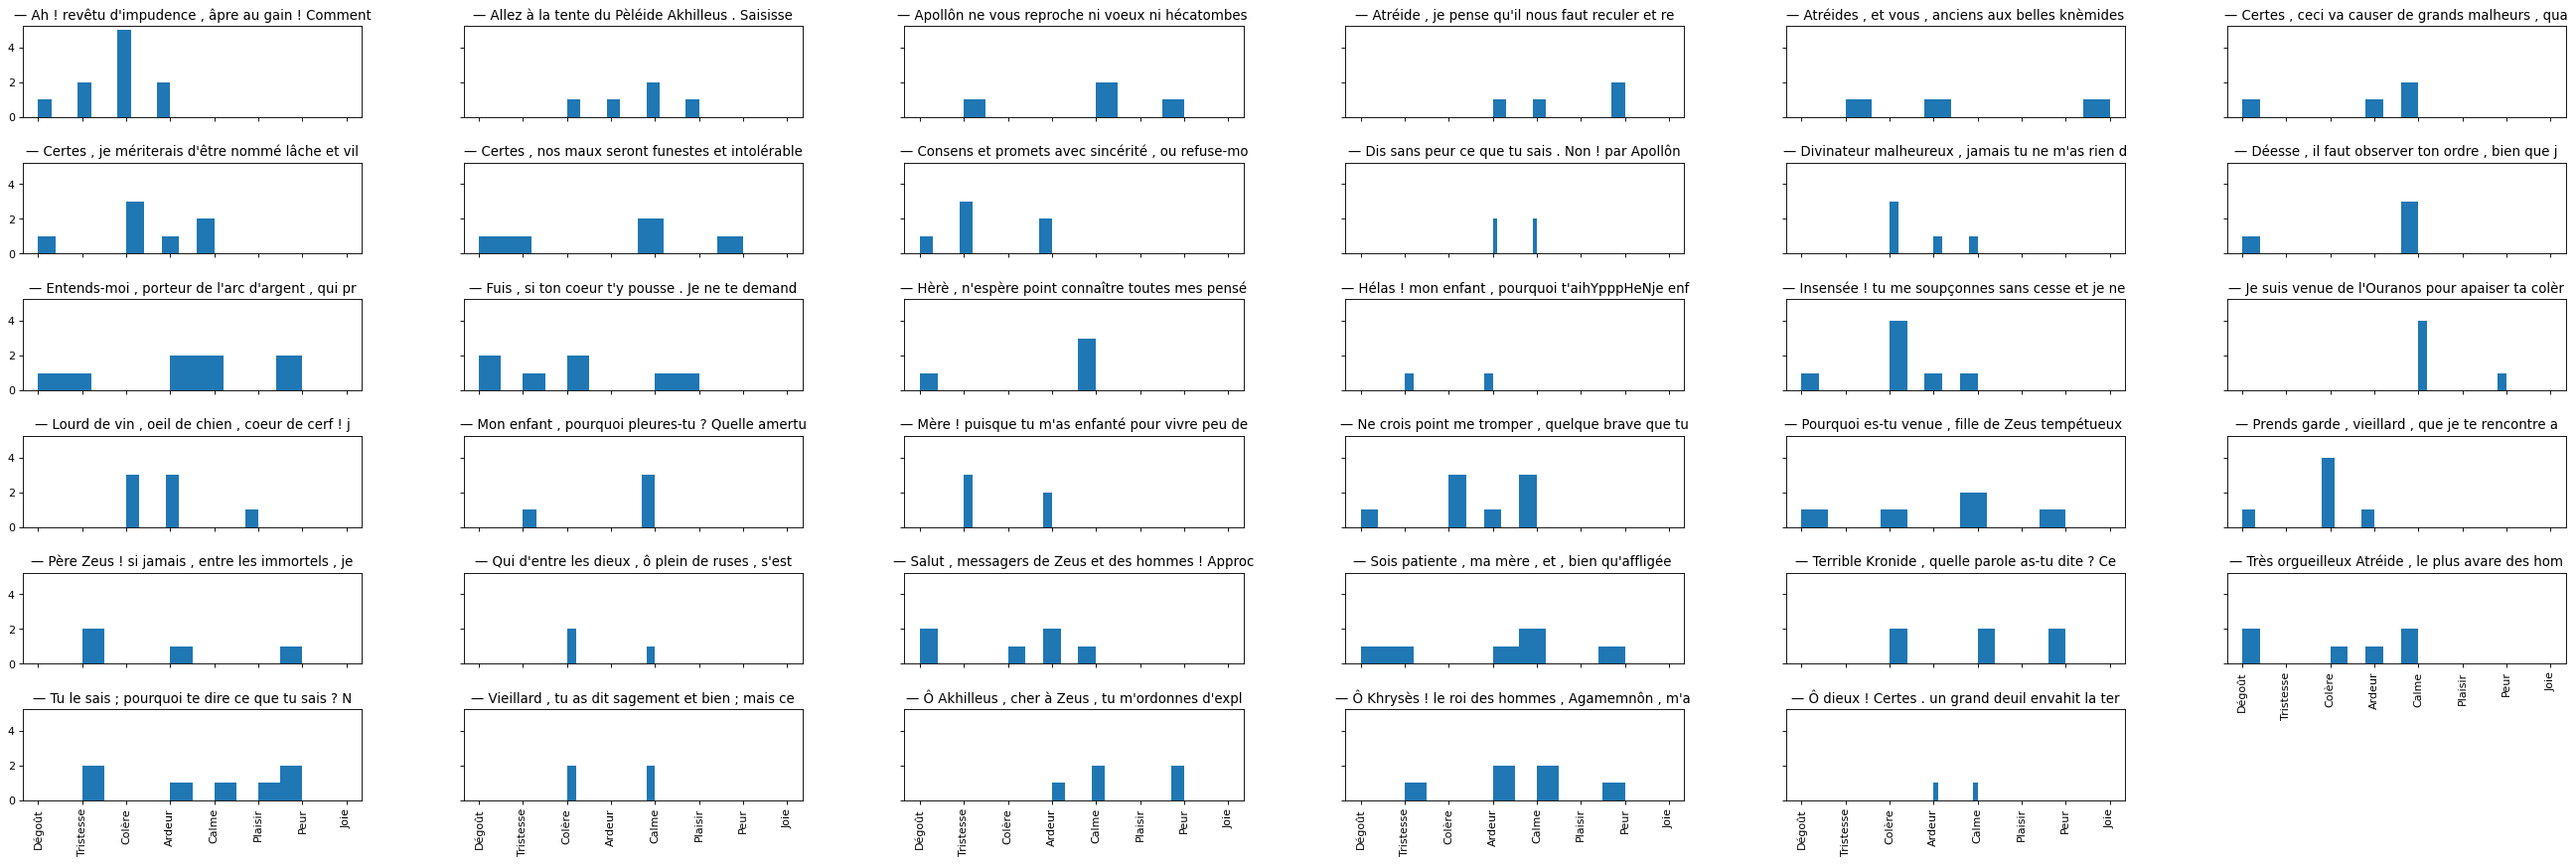

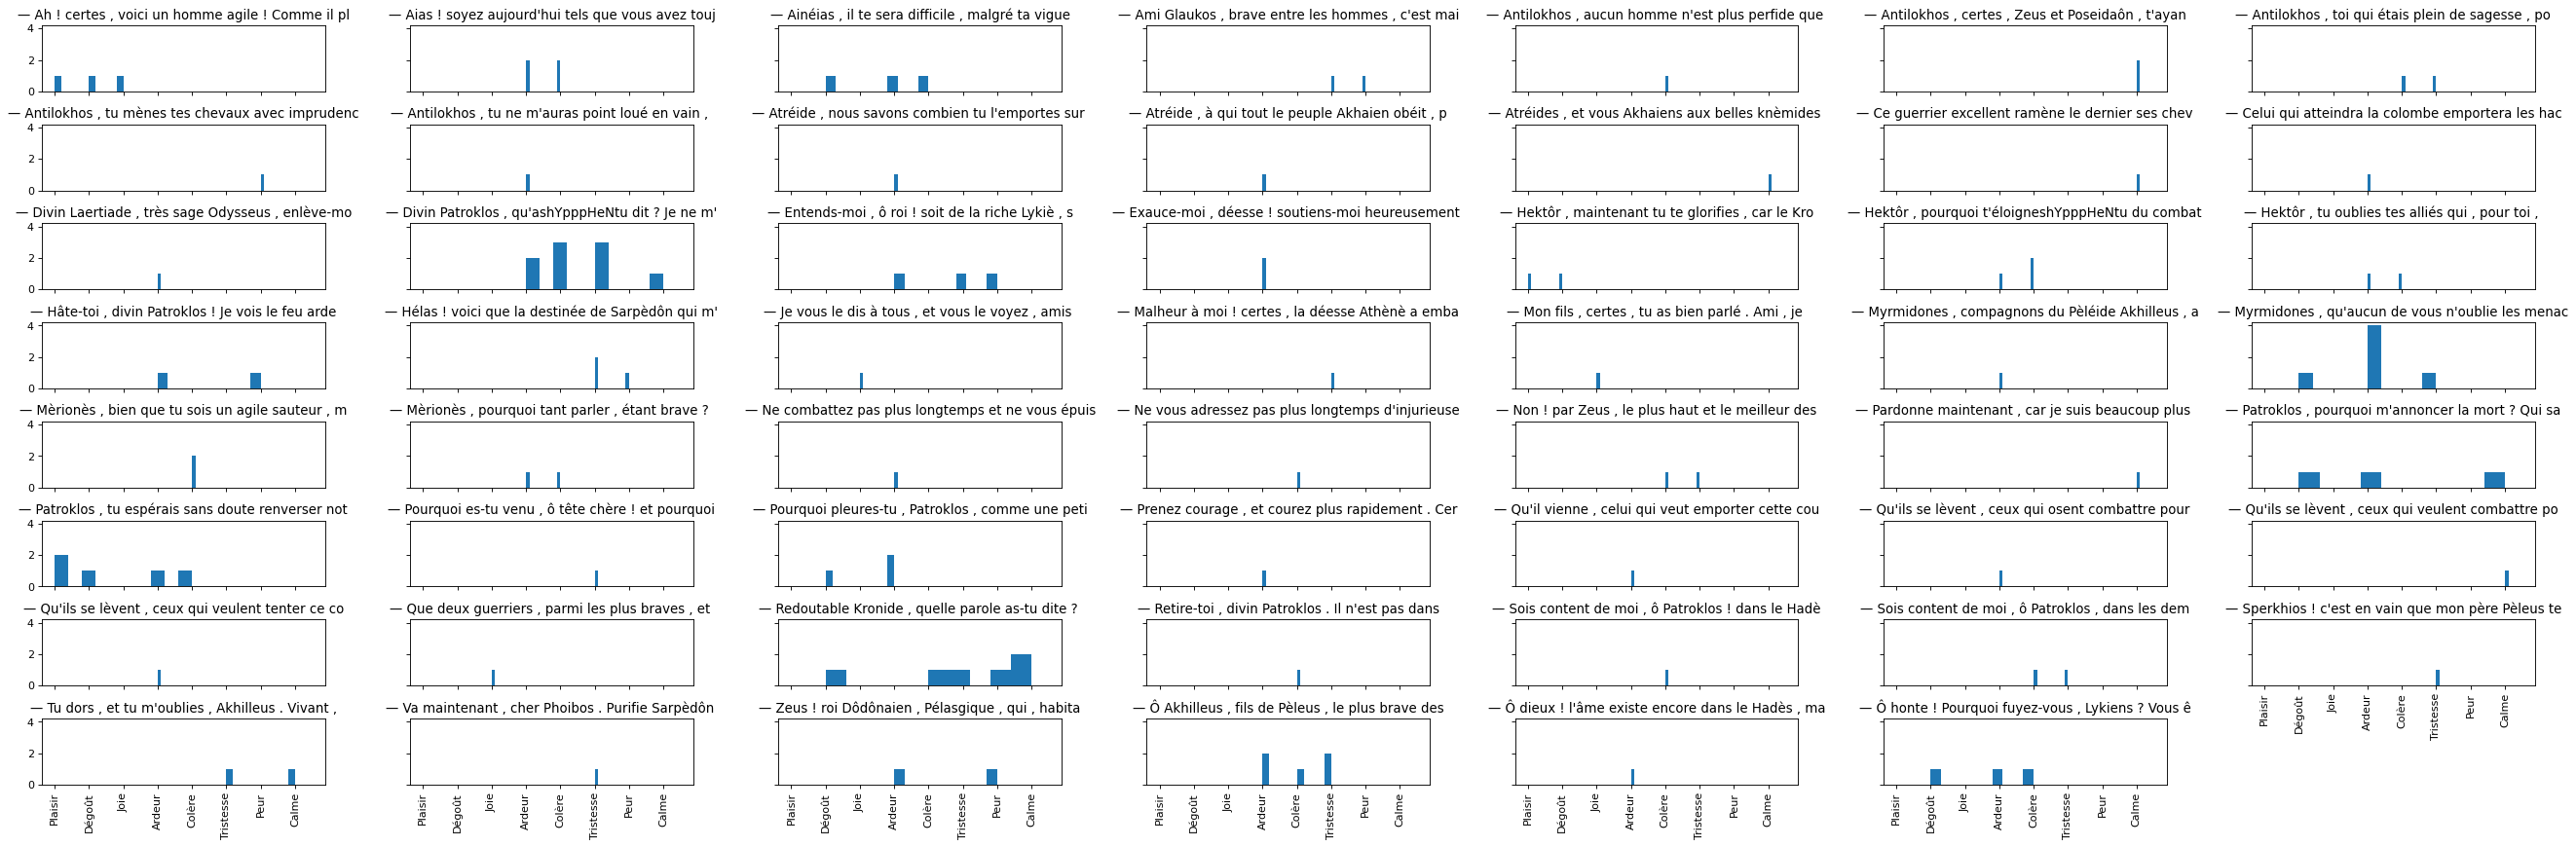

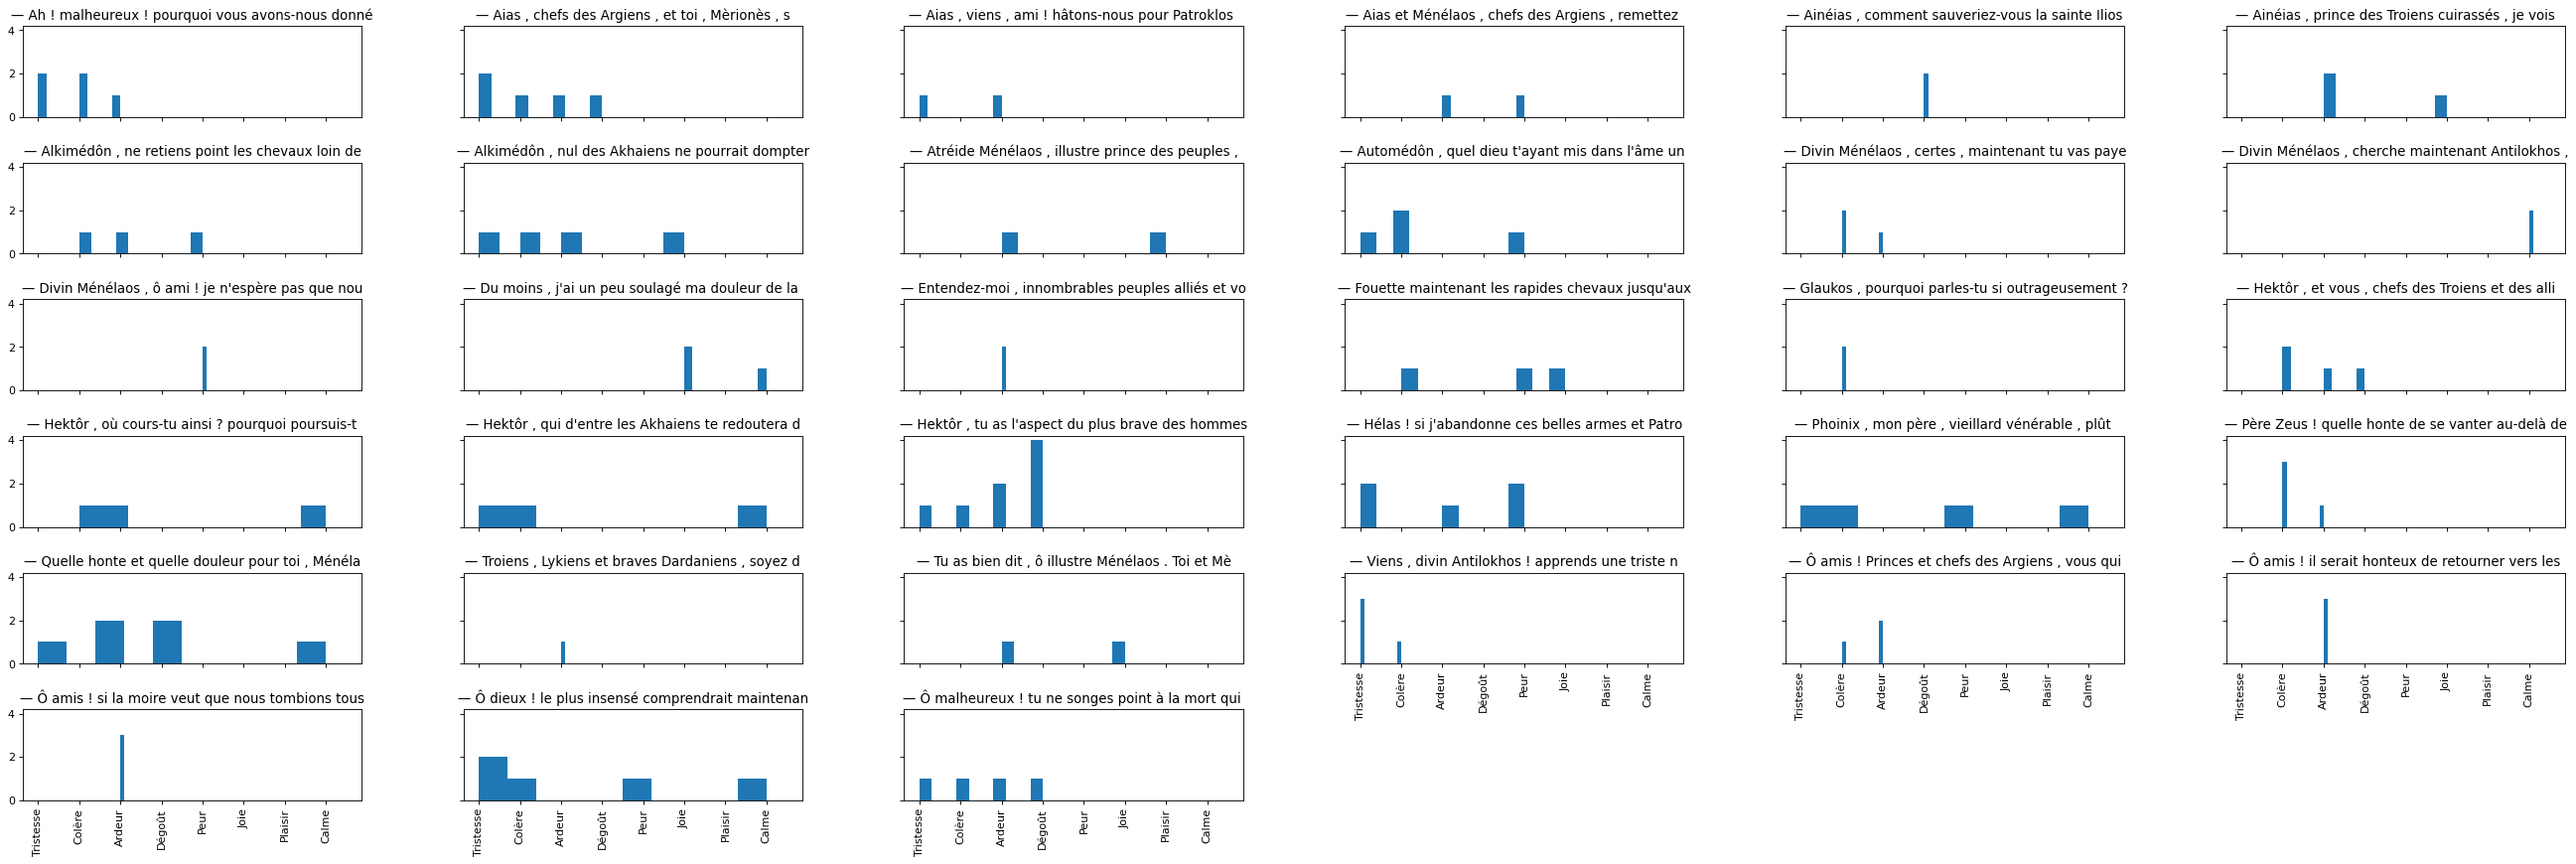

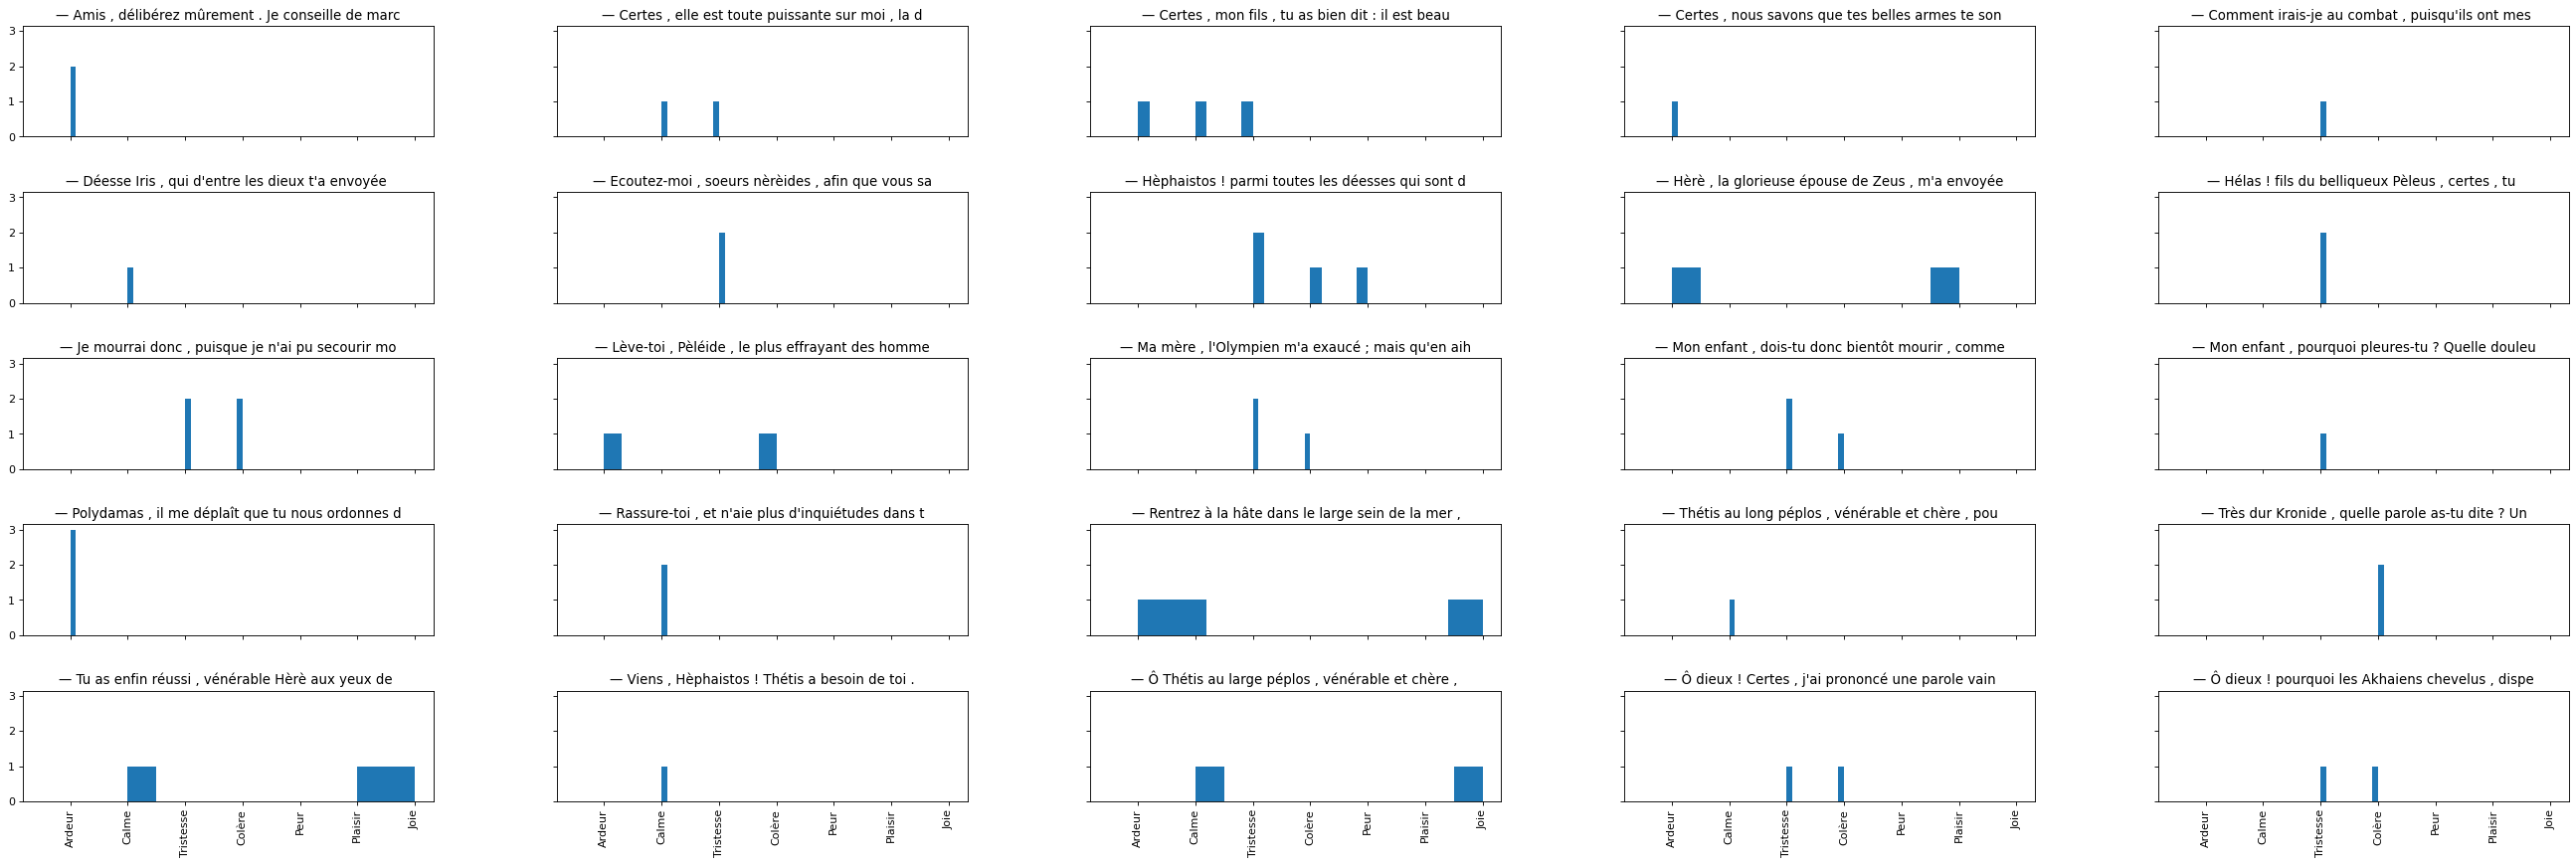

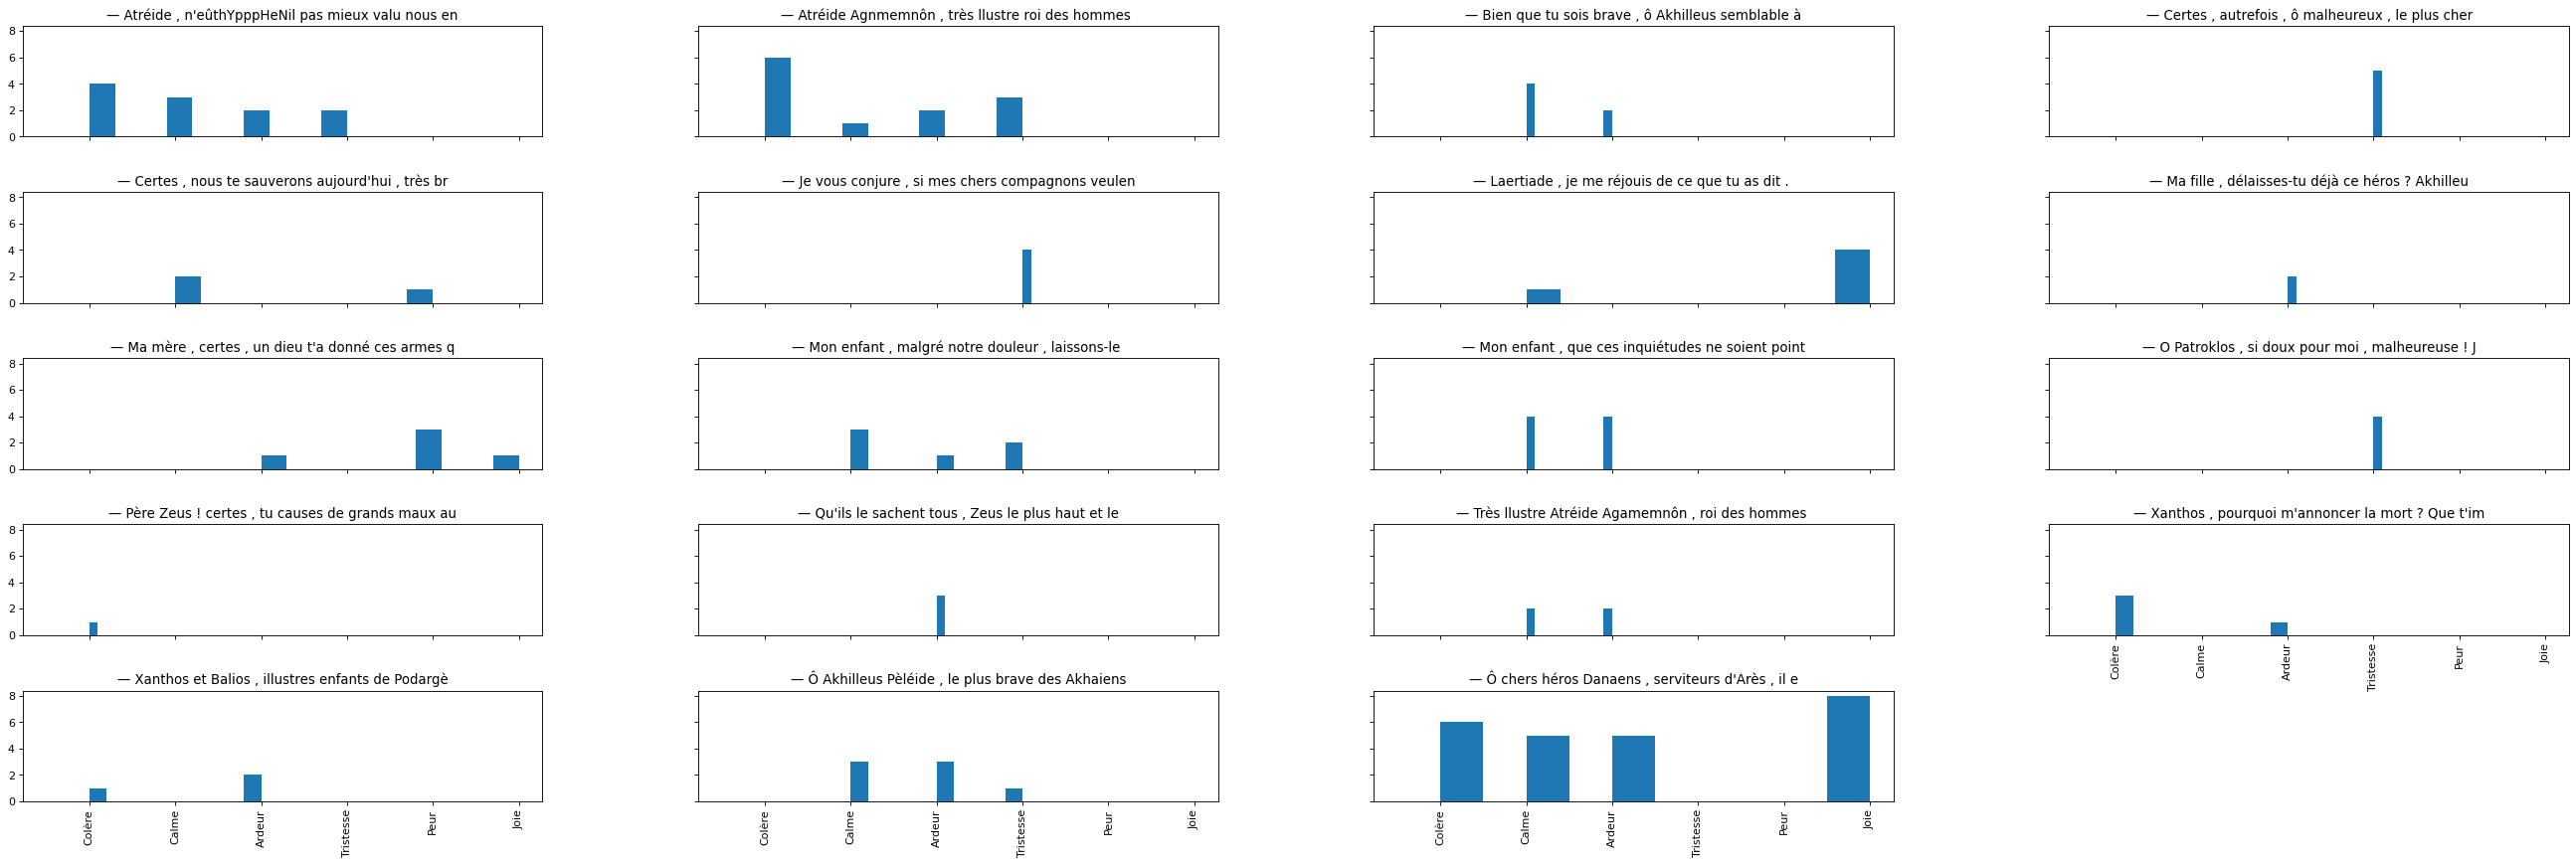

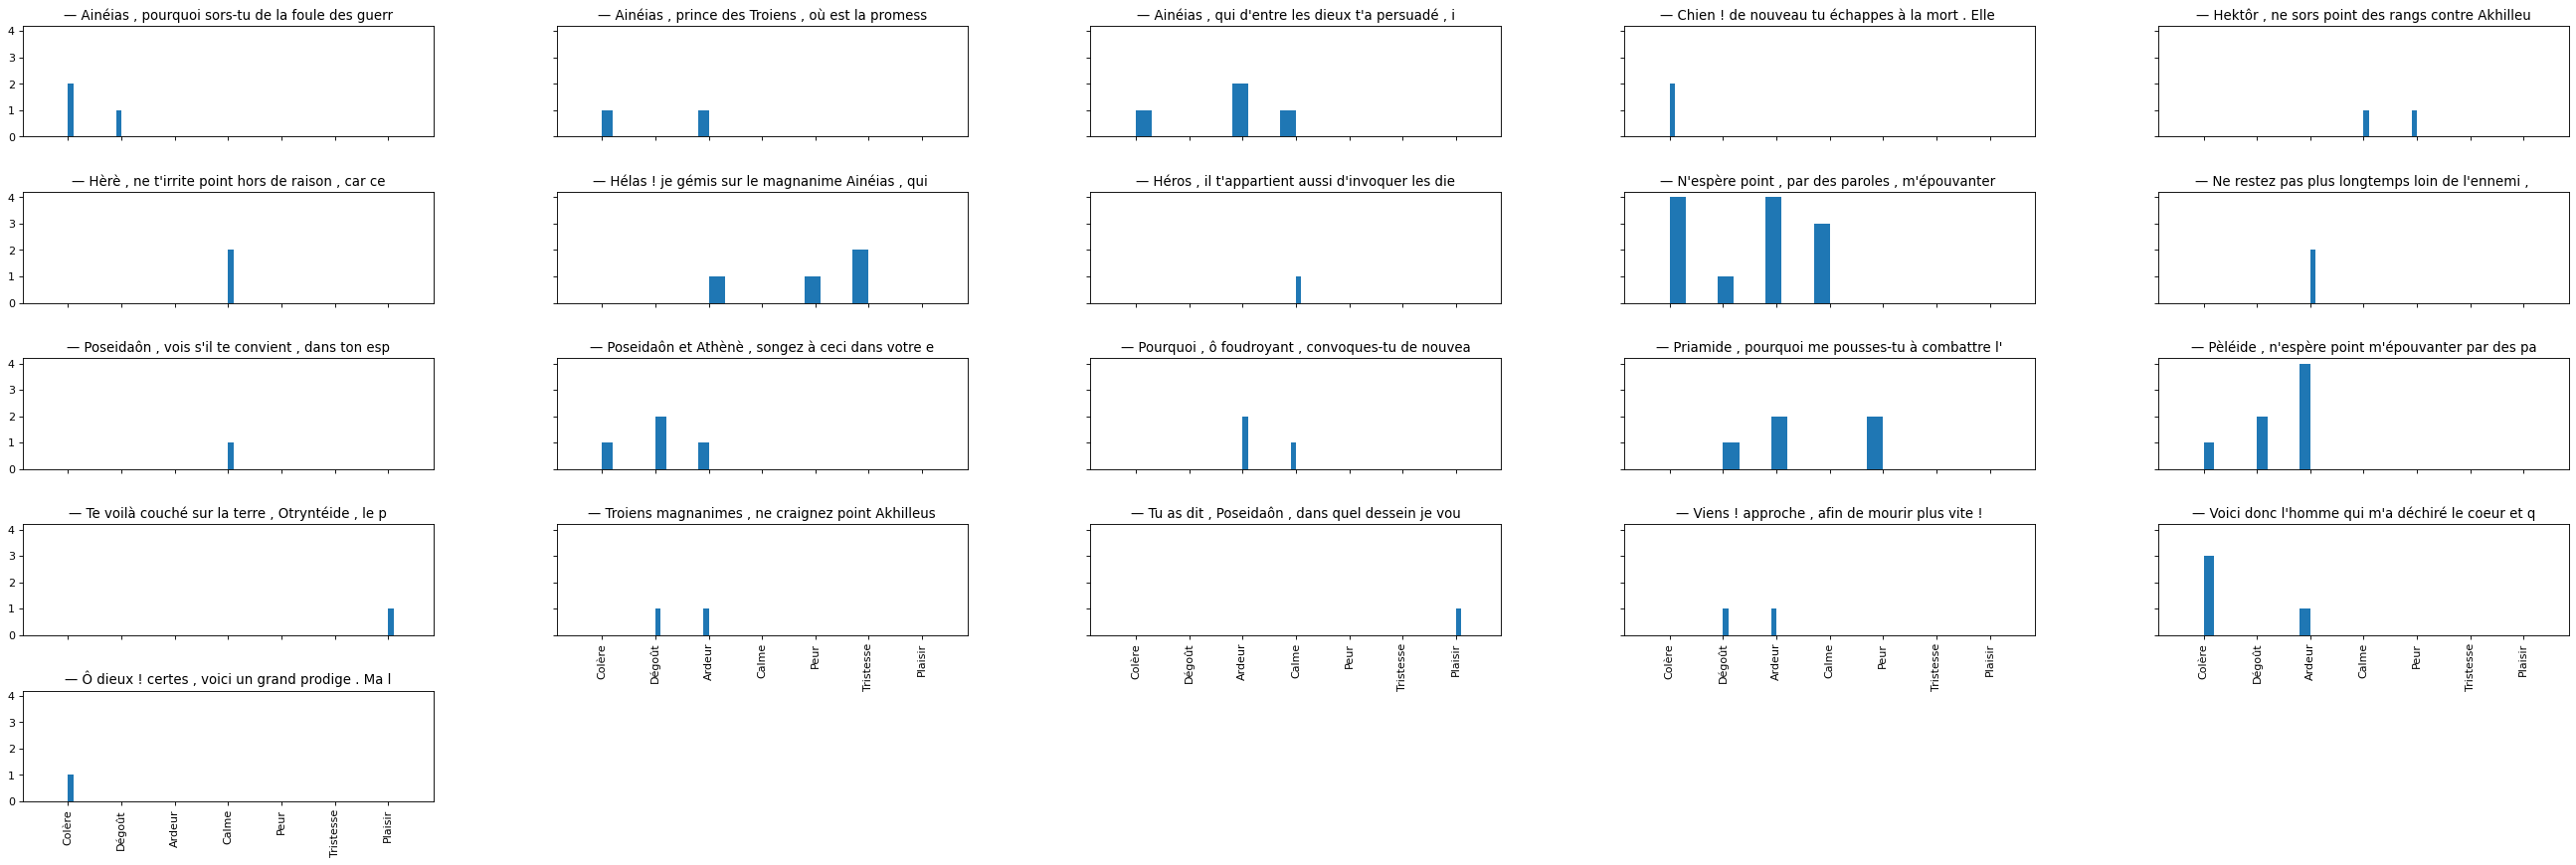

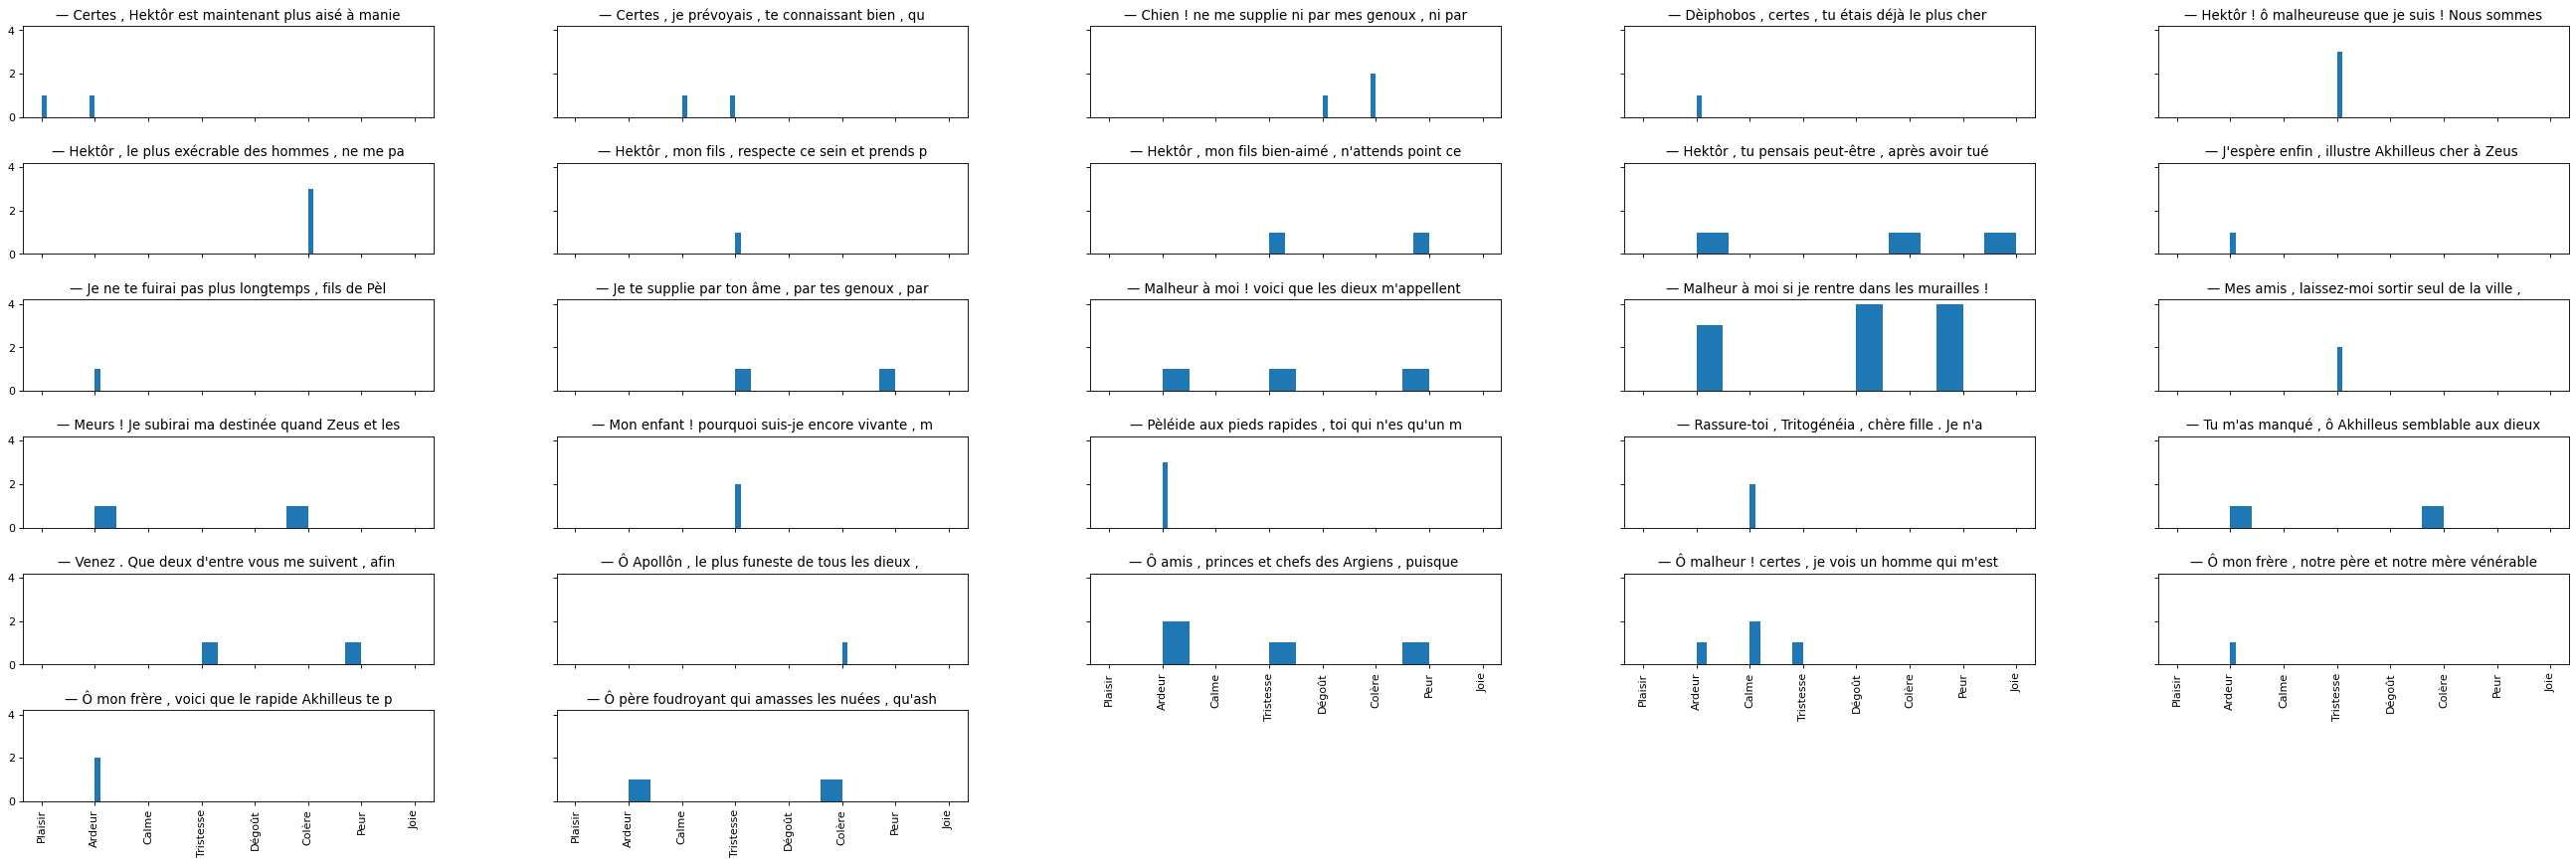

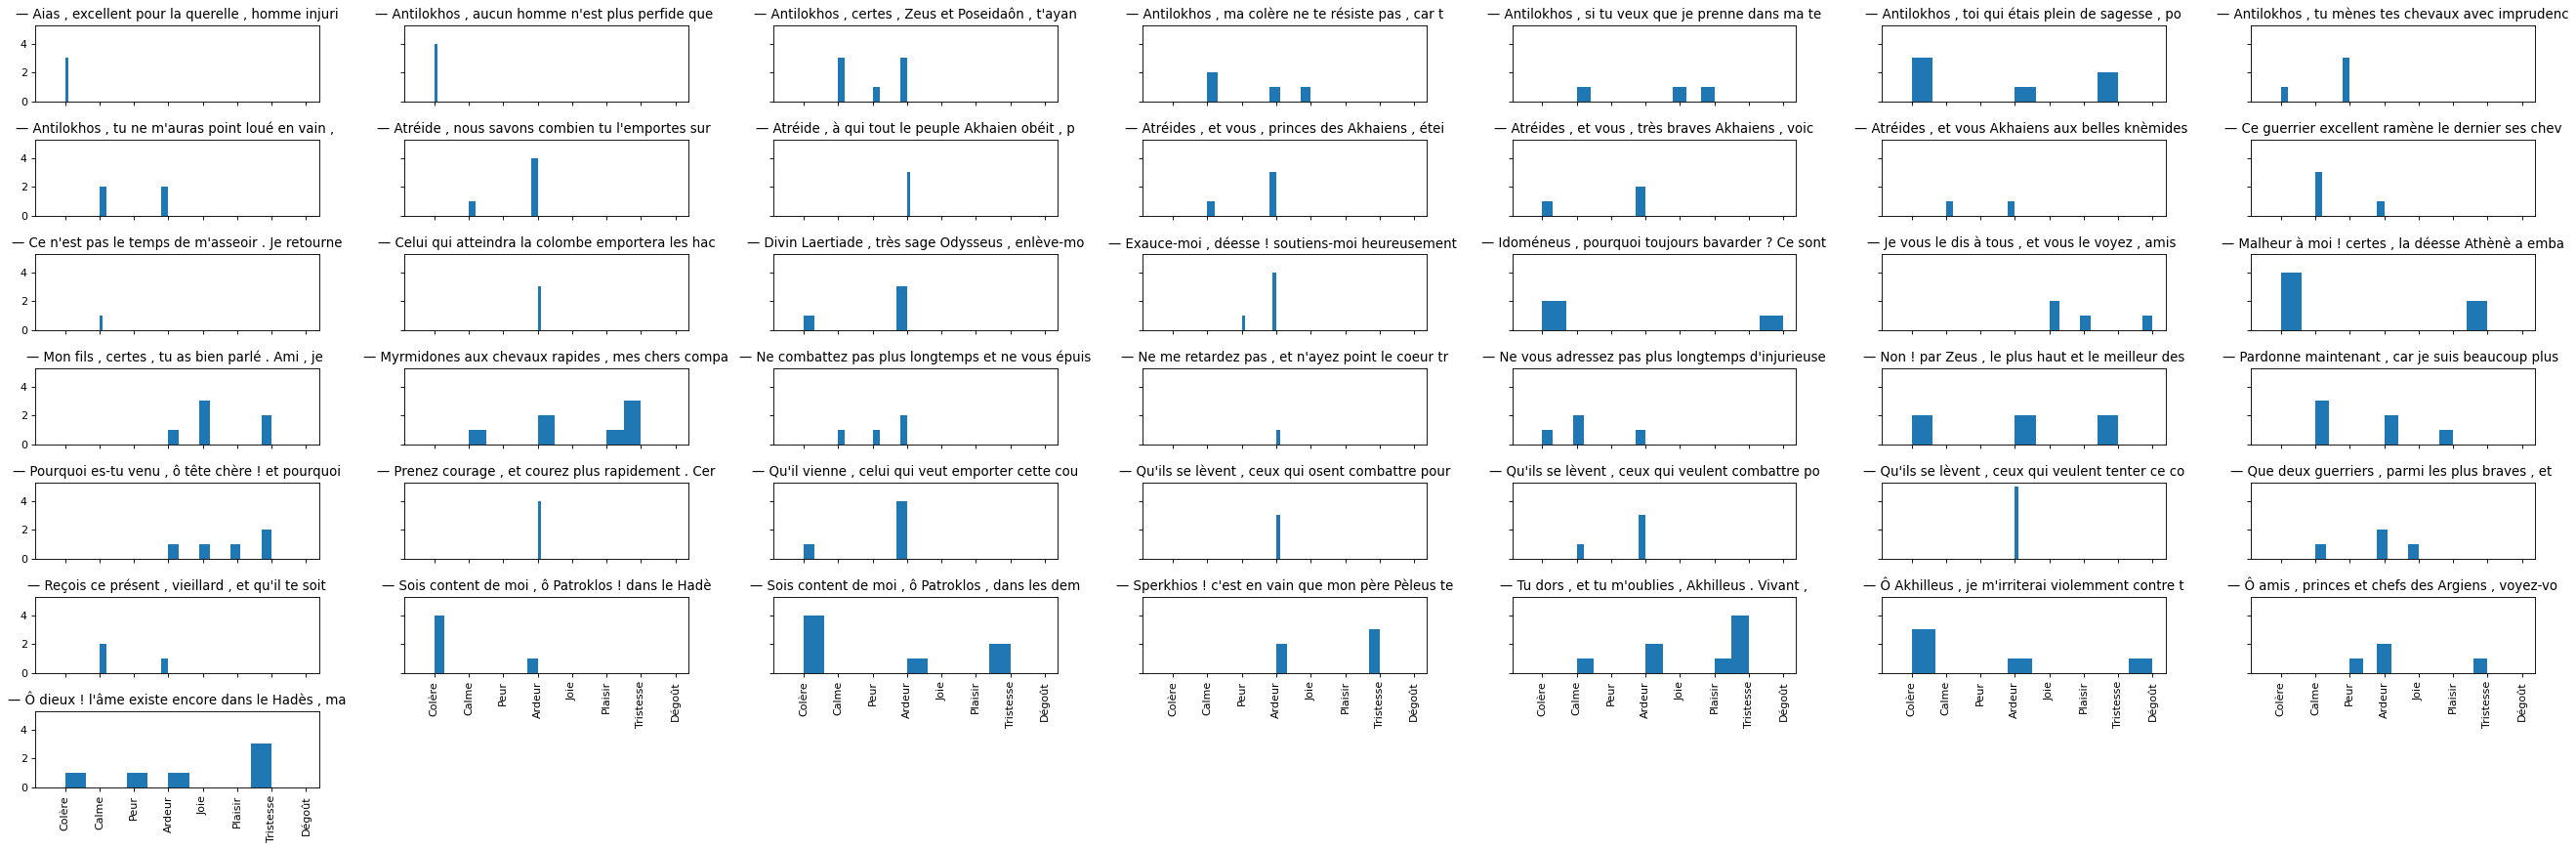

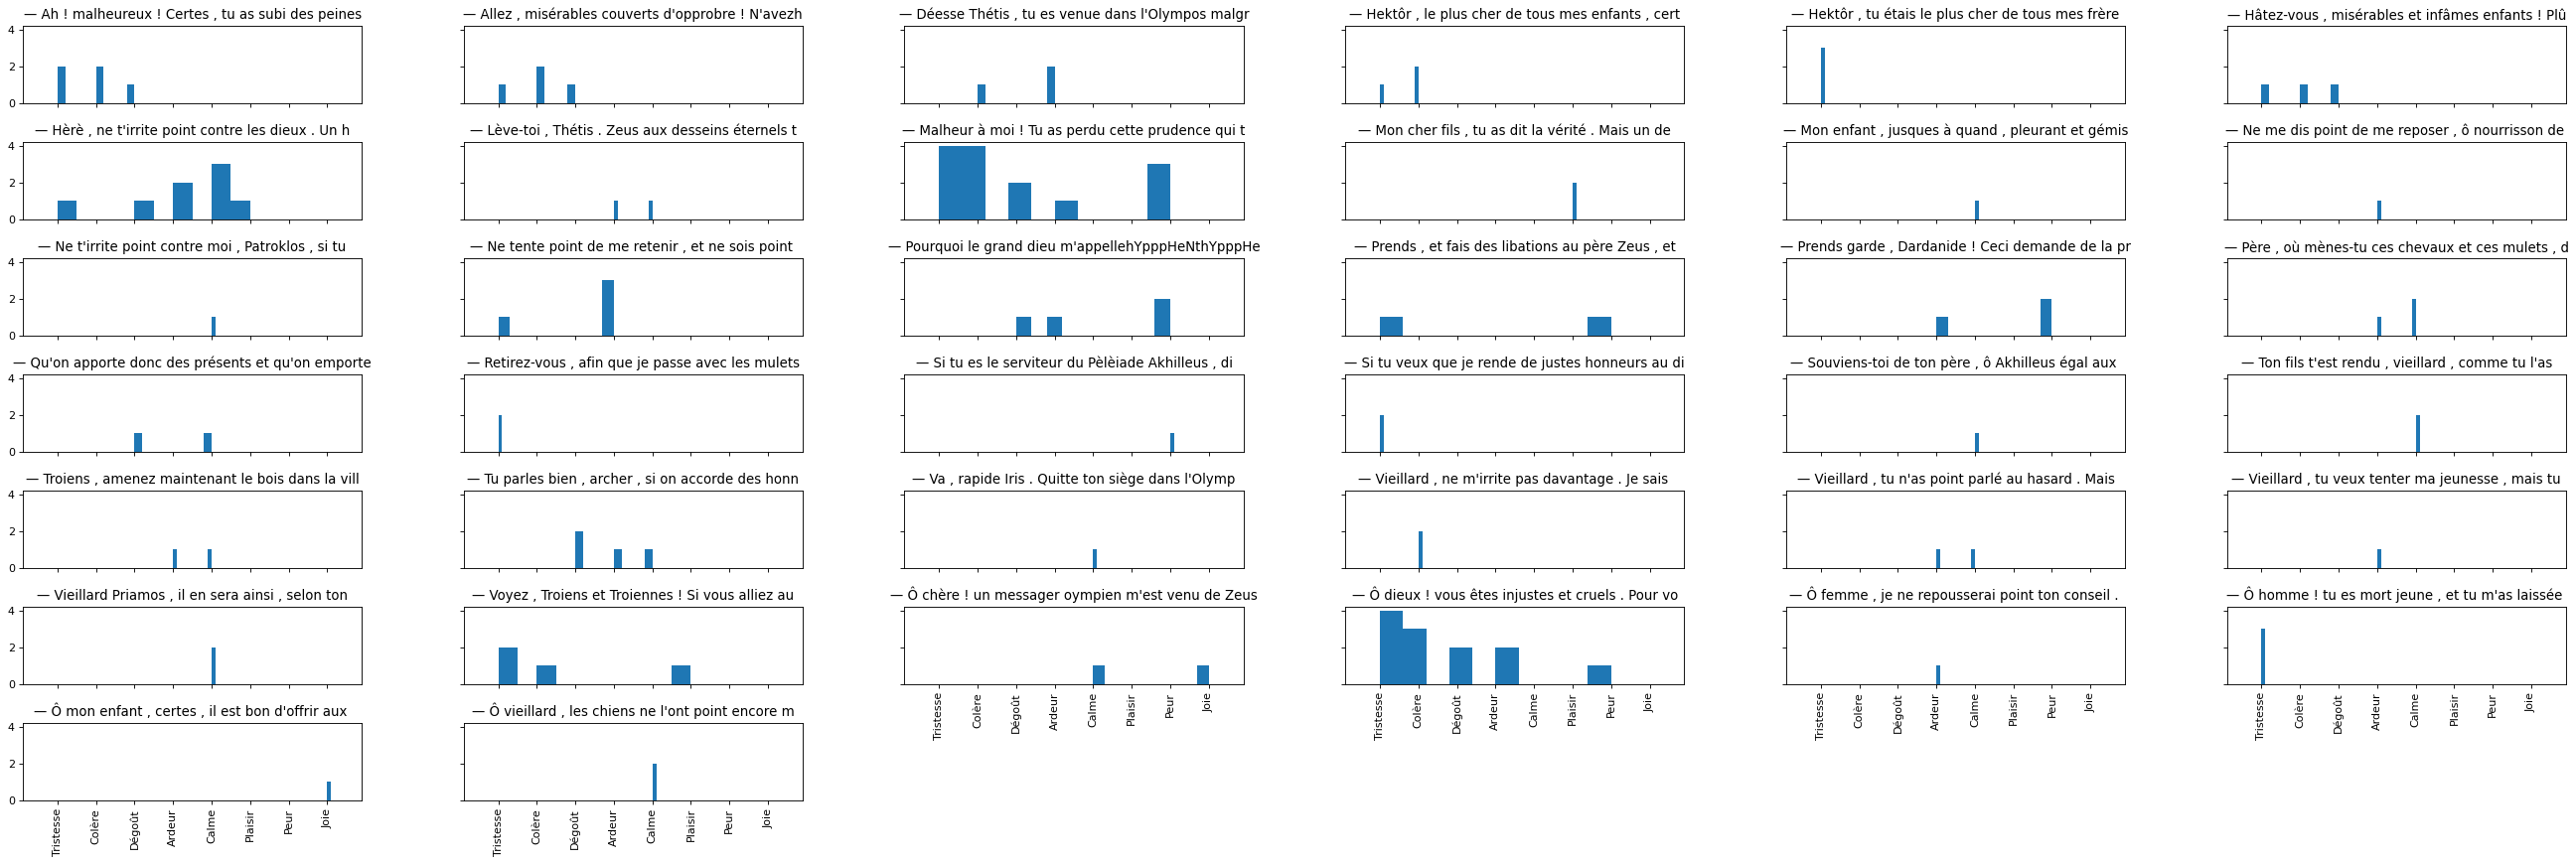

In [5]:
# List of JSONS grouped by chapters
json_list_1 = ['Jsonfiles/ch1_1.json', 'Jsonfiles/ch1_2.json', 'Jsonfiles/ch1_3.json']
json_list_16 = ['Jsonfiles/ch16_1.json', 'Jsonfiles/ch16_2.json', 'Jsonfiles/ch16_3.json']
json_list_17 = ['Jsonfiles/ch17_1.json', 'Jsonfiles/ch17_3.json', 'Jsonfiles/ch17_4.json']
json_list_18 = ['Jsonfiles/ch18_1.json', 'Jsonfiles/ch18_2.json']
json_list_19 = ['Jsonfiles/ch19_1.json', 'Jsonfiles/ch19_2.json', 'Jsonfiles/ch19_3.json', 'Jsonfiles/ch19_4.json']
json_list_20 = ['Jsonfiles/ch20_1.json', 'Jsonfiles/ch20_2.json', 'Jsonfiles/ch20_3.json']
json_list_21 = ['Jsonfiles/ch21_1.json', 'Jsonfiles/ch21_2.json', 'Jsonfiles/ch21_3.json', 'Jsonfiles/ch21_3.json']
json_list_22 = ['Jsonfiles/ch22_1.json', 'Jsonfiles/ch22_2.json', 'Jsonfiles/ch22_3.json']
json_list_23 = ['Jsonfiles/ch23_1.json', 'Jsonfiles/ch23_2.json', 'Jsonfiles/ch23_3.json', 'Jsonfiles/ch23_4.json']
json_list_24 = ['Jsonfiles/ch24_1.json', 'Jsonfiles/ch24_2.json', 'Jsonfiles/ch24_3.json']


# Obtain dataframe, krippendorf value, and graph
chapter_1, kripp_1, graph_1 = merge_dataframes(json_list_1)
chapter_16, kripp_16, graph_16 = merge_dataframes(json_list_16)
chapter_17, kripp_17, graph_17 = merge_dataframes(json_list_17)
chapter_18, kripp_18, graph_18 = merge_dataframes(json_list_18)
chapter_19, kripp_19, graph_19 = merge_dataframes(json_list_19)
chapter_20, kripp_20, graph_20 = merge_dataframes(json_list_20)
#chapter_21, kripp_21, graph_21 = merge_dataframes(json_list_21)
chapter_22, kripp_22, graph_22 = merge_dataframes(json_list_22)
chapter_23, kripp_23, graph_23 = merge_dataframes(json_list_23)
chapter_24, kripp_24, graph_24 = merge_dataframes(json_list_24)

# Get krippendorff graph
krippendorff_series = [kripp_1, kripp_16, kripp_17, kripp_18, kripp_19, kripp_20, kripp_22, kripp_23, kripp_24]
krippendorff_graph(krippendorff_series)

# use this line to display dataframe
chapter_17.apply(lambda a: a[:])

chapters_dict = {
    "chapter_1": chapter_1.apply(lambda a: a[:]),
    "chapter_16": chapter_16.apply(lambda a: a[:]),
    "chapter_17": chapter_17.apply(lambda a: a[:]),
    "chapter_18": chapter_18.apply(lambda a: a[:]),
    "chapter_19": chapter_19.apply(lambda a: a[:]),
    "chapter_20": chapter_20.apply(lambda a: a[:]),
    # "chapter_21": chapter_21.apply(lambda a: a[:]),
    "chapter_22": chapter_22.apply(lambda a: a[:]),
    "chapter_23": chapter_23.apply(lambda a: a[:]),
    "chapter_24": chapter_24.apply(lambda a: a[:])
    }

# Export dataframes as pickle files
for name, df in chapters_dict.items():
    df.to_pickle("pickled_files/" + name + ".pkl")

In [6]:
chapter_1 = chapter_1.apply(lambda a: a[:])
chapter_16 = chapter_16.apply(lambda a: a[:])
chapter_17 = chapter_17.apply(lambda a: a[:])
chapter_18 = chapter_18.apply(lambda a: a[:])
chapter_19 = chapter_19.apply(lambda a: a[:])
chapter_20 = chapter_20.apply(lambda a: a[:])
chapter_22 = chapter_22.apply(lambda a: a[:])
chapter_23 = chapter_23.apply(lambda a: a[:])
chapter_24 = chapter_24.apply(lambda a: a[:])

Krippendorff alfa test for chapter one

In [7]:
chapter_1

data_type  \
original_data                                      rounded_length                 
— Ah ! revêtu d'impudence , âpre au gain ! Comment 10             80    emotion   
                                                   20             81    emotion   
                                                   200            67    emotion   
                                                   210            78    emotion   
                                                   260            68    emotion   
                                                   320            66    emotion   
                                                   550            69    emotion   
                                                   1340           63    emotion   
                                                                  64    emotion   
                                                                  79    emotion   
— Allez à la tente du Pèléide Akhilleus . Saisisse 90             53    emotion   
                                                   120            54    emotion   
                                                   200            55    emotion   
                                                   210            47    emotion   
                                                                  48    emotion   
— Apollôn ne vous reproche ni voeux ni hécatombes  30             76    emotion   
                                                   490            77    emotion   
                                                   520            72    emotion   
                                                                  95    emotion   
— Atréide , je pense qu'il nous faut reculer et re 570            85    emotion   
                                                                  79    emotion   
                                                                  80    emotion   
                                                                  102   emotion   
— Atréides , et vous , anciens aux belles knèmides 130            13    emotion   
                                                   180            12    emotion   
                                                   270            109   emotion   
— Certes , ceci va causer de grands malheurs , qua 260            27    emotion   
                                                   340            28    emotion   
                                                   600            31    emotion   
                                                                  19    emotion   
— Certes , je mériterais d'être nommé lâche et vil 80             59    emotion   
                                                   110            47    emotion   
                                                   120            57    emotion   
                                                   490            48    emotion   
                                                                  58    emotion   
                                                   600            50    emotion   
                                                                  51    emotion   
— Certes , nos maux seront funestes et intolérable 210            18    emotion   
                                                   410            19    emotion   
                                                   620            20    emotion   
                                                                  21    emotion   
                                                                  4     emotion   
— Consens et promets avec sincérité , ou refuse-mo 50             31    emotion   
                                                                  22    emotion   
                                                   80             30    emotion   
                                                   140            33    emotion   
                                                                  34    emotion   
   

In [8]:
chapter_1.reset_index(inplace=True, drop=True)

In [9]:
kripp = sf.calculate_krippendorffs_alpha_for_df(
    chapter_1, experiment_col='original_data', annotator_col='annotator', class_col='label')
print(kripp)

0.13479623824451403


Krippendorff alfa test for chapter one (tutorial)

In [11]:
def df_to_experiment_annotator_table(df,experiment_col,annotator_col,class_col):
        return df.pivot_table(
        index=annotator_col, columns=experiment_col, values=class_col, aggfunc="first"
    )

chapter1= df_to_experiment_annotator_table(chapter_1,'original_data','annotator', 'label')

In [28]:
def make_value_by_unit_table_dict(experiment_annotator_df):
    """

    :param experiment_annotator_df: A dataframe that came out of  df_to_experiment_annotator_table
    :return: A dictionary of dictionaries (e.g. a table) whose rows (first level) are experiments and columns are responses
            {1: Counter({1.0: 1}),
             2: Counter(),
             3: Counter({2.0: 2}),
             4: Counter({1.0: 2}),
             5: Counter({3.0: 2}),
            """
    data_by_exp = experiment_annotator_df.T.sort_index(axis=1).sort_index()
    table_dict = {}
    for exp, row in data_by_exp.iterrows():
        vals = row.dropna().values
        table_dict[exp] = Counter()
        for val in vals:
            table_dict[exp][val] += 1
    return table_dict

In [29]:
def calculate_frequency_dicts(vbu_table_dict):
    """

    :param vbu_table_dict: A value by unit table dictionary, the output of  make_value_by_unit_table_dict
    :return: A dictionary of dictonaries
        {
            unit_freqs:{ 1:2..},
            class_freqs:{ 3:4..},
            total:7
        }
    """
    vbu_df = (
        pd.DataFrame.from_dict(vbu_table_dict, orient="index")
        .T.sort_index(axis=0)
        .sort_index(axis=1)
        .fillna(0)
    )
    ubv_df = vbu_df.T
    vbu_df_masked = ubv_df.mask(ubv_df.sum(1) == 1, other=0).T
    return dict(
        unit_freqs=vbu_df_masked.sum().to_dict(),
        class_freqs=vbu_df_masked.sum(1).to_dict(),
        total=vbu_df_masked.sum().sum(),
    )

In [30]:
def calculate_de(frequency_dicts, metric_fn):
    """
    Calculates the expected disagreement by chance
    :param frequency_dicts: The output of data_transforms.calculate_frequency_dicts e.g.:
        {
            unit_freqs:{ 1:2..},
            class_freqs:{ 3:4..},
            total:7
        }
    :param metric_fn metric function such as nominal_metric
    :return: De a float
    """
    De = 0
    class_freqs = frequency_dicts["class_freqs"]
    class_names = list(class_freqs.keys())
    for i, c in enumerate(class_names):
        for k in class_names:
            De += class_freqs[c] * class_freqs[k] * metric_fn(c, k)
    return De

In [31]:
def calculate_do(vbu_table_dict, frequency_dicts, metric_fn):
    """

    :param vbu_table_dict: Output of data_transforms.make_value_by_unit_table_dict
    :param frequency_dicts: The output of data_transforms.calculate_frequency_dicts e.g.:
        {
            unit_freqs:{ 1:2..},
            class_freqs:{ 3:4..},
            total:7
        }
    :param metric_fn: metric_fn metric function such as nominal_metric
    :return:  Do a float
    """
    Do = 0
    unit_freqs = frequency_dicts["unit_freqs"]
    unit_ids = list(unit_freqs.keys())
    for unit_id in unit_ids:
        unit_classes = list(vbu_table_dict[unit_id].keys())
        if unit_freqs[unit_id] < 2:
            pass
        else:
            weight = 1 / (unit_freqs[unit_id] - 1)
            for i, c in enumerate(unit_classes):
                for k in unit_classes:
                    Do += (
                        vbu_table_dict[unit_id][c]
                        * vbu_table_dict[unit_id][k]
                        * weight
                        * metric_fn(c, k)
                    )
    return Do

In [32]:
def calculate_krippendorffs_alpha(ea_table_df, metric_fn=nominal_metric):
    """

    :param ea_table_df: The Experiment/Annotator table, output from data_transforms.df_to_experiment_annotator_table
    :param metric_fn: The metric function. Defaults to nominal
    :return: Alpha, a float
    """
    vbu_table_dict = data_transforms.make_value_by_unit_table_dict(ea_table_df)
    frequency_dict = data_transforms.calculate_frequency_dicts(vbu_table_dict)
    observed_disagreement = calculate_do(
        vbu_table_dict=vbu_table_dict,
        frequency_dicts=frequency_dict,
        metric_fn=metric_fn,
    )
    expected_disagreement = calculate_de(
        frequency_dicts=frequency_dict, metric_fn=metric_fn
    )
    N = frequency_dict['total']
    alpha = 1 - (observed_disagreement / expected_disagreement)*(N-1)
    return alpha

In [12]:
chapter1

original_data,"— Ah ! revêtu d'impudence , âpre au gain ! Comment",— Allez à la tente du Pèléide Akhilleus . Saisisse,— Apollôn ne vous reproche ni voeux ni hécatombes,"— Atréide , je pense qu'il nous faut reculer et re","— Atréides , et vous , anciens aux belles knèmides","— Certes , ceci va causer de grands malheurs , qua","— Certes , je mériterais d'être nommé lâche et vil","— Certes , nos maux seront funestes et intolérable","— Consens et promets avec sincérité , ou refuse-mo",— Dis sans peur ce que tu sais . Non ! par Apollôn,"— Divinateur malheureux , jamais tu ne m'as rien d","— Déesse , il faut observer ton ordre , bien que j","— Entends-moi , porteur de l'arc d'argent , qui pr","— Fuis , si ton coeur t'y pousse . Je ne te demand","— Hèrè , n'espère point connaître toutes mes pensé","— Hélas ! mon enfant , pourquoi t'aihYpppHeNje enf",— Insensée ! tu me soupçonnes sans cesse et je ne,— Je suis venue de l'Ouranos pour apaiser ta colèr,"— Lourd de vin , oeil de chien , coeur de cerf ! j","— Mon enfant , pourquoi pleures-tu ? Quelle amertu",— Mère ! puisque tu m'as enfanté pour vivre peu de,"— Ne crois point me tromper , quelque brave que tu","— Pourquoi es-tu venue , fille de Zeus tempétueux","— Prends garde , vieillard , que je te rencontre a","— Père Zeus ! si jamais , entre les immortels , je","— Qui d'entre les dieux , ô plein de ruses , s'est","— Salut , messagers de Zeus et des hommes ! Approc","— Sois patiente , ma mère , et , bien qu'affligée","— Terrible Kronide , quelle parole as-tu dite ? Ce","— Très orgueilleux Atréide , le plus avare des hom",— Tu le sais ; pourquoi te dire ce que tu sais ? N,"— Vieillard , tu as dit sagement et bien ; mais ce","— Ô Akhilleus , cher à Zeus , tu m'ordonnes d'expl","— Ô Khrysès ! le roi des hommes , Agamemnôn , m'a",— Ô dieux ! Certes . un grand deuil envahit la ter
annotator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Tristesse,NaN,Tristesse,Peur,Tristesse,Dégoût,Dégoût,Dégoût,Tristesse,Ardeur,Colère,Dégoût,Peur,Plaisir,Calme,NaN,Dégoût,Peur,Plaisir,Calme,Tristesse,Ardeur,Dégoût,Colère,Tristesse,Colère,NaN,Calme,Colère,Calme,Tristesse,Colère,Ardeur,Ardeur,NaN
1,Colère,Colère,Calme,Calme,NaN,Calme,Colère,Tristesse,Tristesse,Calme,Colère,Calme,Peur,Dégoût,Calme,NaN,Colère,Calme,Colère,Calme,Ardeur,Calme,Calme,Ardeur,NaN,NaN,Calme,Calme,Colère,Dégoût,Calme,Calme,Calme,Tristesse,NaN
2,Colère,Plaisir,Calme,Ardeur,Ardeur,Calme,Colère,Calme,Tristesse,Calme,Calme,Calme,Ardeur,Calme,Dégoût,Ardeur,Colère,Calme,Ardeur,Tristesse,Ardeur,Colère,NaN,Colère,Tristesse,Colère,Dégoût,Peur,Peur,Dégoût,Plaisir,Colère,Calme,Ardeur,Ardeur


In [63]:
emotions_df = chapter_1[['label']]

In [64]:
tristesse_df = emotions_df.replace(['Plaisir','Colère', 'Calme', 'Dégoût', 'Peur','Joie', 'Ardeur'],value ="Placeholder")
tristesse_df.rename(columns = {'label':'Tristesse',}, inplace = True)
tristesse_df

,Tristesse
0,Placeholder
1,Placeholder
2,Tristesse
3,Placeholder
4,Placeholder
5,Placeholder
6,Tristesse
7,Placeholder
8,Placeholder
9,Placeholder


In [65]:
colere_df = emotions_df.replace(['Tristesse','Plaisir', 'Calme', 'Dégoût', 'Peur','Joie', 'Ardeur' ],value ="Placeholder")
colere_df.rename(columns = {'label':'Colère',}, inplace = True)
colere_df

,Colère
0,Colère
1,Colère
2,Placeholder
3,Colère
4,Colère
5,Placeholder
6,Placeholder
7,Colère
8,Placeholder
9,Placeholder


In [66]:
ardeur_df = emotions_df.replace(['Tristesse','Plaisir','Colère', 'Calme', 'Dégoût', 'Peur','Joie'],value ="Placeholder")
ardeur_df.rename(columns = {'label':'Ardeur',}, inplace = True)
ardeur_df

,Ardeur
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Placeholder
6,Placeholder
7,Placeholder
8,Ardeur
9,Ardeur


In [67]:
plaisir_df = emotions_df.replace(['Tristesse','Colère', 'Calme', 'Dégoût', 'Peur','Joie', 'Ardeur'],value ="Placeholder")
plaisir_df.rename(columns = {'label':'Plaisir',}, inplace = True)
plaisir_df

,Plaisir
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Placeholder
6,Placeholder
7,Placeholder
8,Placeholder
9,Placeholder


In [68]:
calme_df = emotions_df.replace(['Tristesse','Plaisir','Colère', 'Dégoût', 'Peur','Joie', 'Ardeur'],value ="Placeholder")
calme_df.rename(columns = {'label':'Calme',}, inplace = True)
calme_df

,Calme
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Placeholder
6,Placeholder
7,Placeholder
8,Placeholder
9,Placeholder


In [69]:
degout_df = emotions_df.replace(['Tristesse','Plaisir','Colère', 'Calme', 'Peur','Joie', 'Ardeur'],value ="Placeholder")
degout_df.rename(columns = {'label':'Dégoût',}, inplace = True)
degout_df

,Dégoût
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Dégoût
6,Placeholder
7,Placeholder
8,Placeholder
9,Placeholder


In [72]:
peur_df = emotions_df.replace(['Tristesse','Plaisir','Colère', 'Calme', 'Dégoût','Joie', 'Ardeur'],value ="Placeholder")
peur_df.rename(columns = {'label':'Peur',}, inplace = True)
peur_df

,Peur
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Placeholder
6,Placeholder
7,Placeholder
8,Placeholder
9,Placeholder


In [73]:
joie_df = emotions_df.replace(['Tristesse','Plaisir','Colère', 'Calme', 'Dégoût', 'Peur', 'Ardeur'],value ="Placeholder")
joie_df.rename(columns = {'label':'Joie',}, inplace = True)
joie_df

,Joie
0,Placeholder
1,Placeholder
2,Placeholder
3,Placeholder
4,Placeholder
5,Placeholder
6,Placeholder
7,Placeholder
8,Placeholder
9,Placeholder


In [74]:
df_emotions_all = pd.concat([chapter_1, tristesse_df, colere_df, ardeur_df, plaisir_df, calme_df, degout_df, peur_df , joie_df ], axis=1)

In [106]:
emotions = df_emotions_all.apply(lambda a: a[:])

In [111]:
emotions

,data_type,start,end,text,label,annotator,id,original_data,speaker,rounded_length,Tristesse,Colère,Ardeur,Plaisir,Calme,Dégoût,Peur,Joie
0,emotion,569,579,impudent !,Colère,2,21,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,10,Placeholder,Colère,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
1,emotion,610,625,oeil de chien !,Colère,2,21,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,20,Placeholder,Colère,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
2,emotion,323,525,Jamais ils ne m'ont enlevé ni mes boeufs ni me...,Tristesse,0,24,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,200,Tristesse,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
3,emotion,2,208,"Ah ! revêtu d'impudence , âpre au gain ! Comme...",Colère,2,21,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,210,Placeholder,Colère,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
4,emotion,528,789,"Mais nous t'avons suivi pour te plaire , impud...",Colère,0,24,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,260,Placeholder,Colère,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
5,emotion,2,320,"Ah ! revêtu d'impudence , âpre au gain ! Comme...",Dégoût,0,24,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,320,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Dégoût,Placeholder,Placeholder
6,emotion,792,1345,"Certes , je n'ai jamais une part égale à la ti...",Tristesse,0,24,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,550,Tristesse,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
7,emotion,2,1347,"Ah ! revêtu d'impudence , âpre au gain ! Comme...",Colère,1,22,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus aux pieds rapides,1340,Placeholder,Colère,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
8,emotion,2,1347,"Ah ! revêtu d'impudence , âpre au gain ! Comme...",Ardeur,1,22,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus aux pieds rapides,1340,Placeholder,Placeholder,Ardeur,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder
9,emotion,2,1345,"Ah ! revêtu d'impudence , âpre au gain ! Comme...",Ardeur,2,21,"— Ah ! revêtu d'impudence , âpre au gain ! Com...",Akhilleus,1340,Placeholder,Placeholder,Ardeur,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder


In [107]:
df_emotions_all.reset_index(inplace=True, drop=True)

In [132]:
def foo(gr):
    kripps = sf.calculate_krippendorffs_alpha_for_df(df, experiment_col='original_data', annotator_col='annotator',class_col='label')
    print(kripps)


In [134]:
emo_df = emotions.groupby('original_data').apply(foo)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [116]:
d = dict(tuple(emotions.groupby(['original_data', 'rounded_length'])))

In [120]:
gb = emotions.groupby(['original_data', 'rounded_length'])    
[gb.get_group(x) for x in gb.groups]


[  data_type  start  end        text   label  annotator  id  \
 0   emotion    569  579  impudent !  Colère          2  21   
 
                                        original_data    speaker  \
 0  — Ah ! revêtu d'impudence , âpre au gain ! Com...  Akhilleus   
 
    rounded_length    Tristesse  Colère       Ardeur      Plaisir        Calme  \
 0              10  Placeholder  Colère  Placeholder  Placeholder  Placeholder   
 
         Dégoût         Peur         Joie  
 0  Placeholder  Placeholder  Placeholder  ,
   data_type  start  end             text   label  annotator  id  \
 1   emotion    610  625  oeil de chien !  Colère          2  21   
 
                                        original_data    speaker  \
 1  — Ah ! revêtu d'impudence , âpre au gain ! Com...  Akhilleus   
 
    rounded_length    Tristesse  Colère       Ardeur      Plaisir        Calme  \
 1              20  Placeholder  Colère  Placeholder  Placeholder  Placeholder   
 
         Dégoût         Peur         

In [129]:
gb = emotions.groupby(['original_data', 'rounded_length'])
[gb.get_group(x) for x in gb.groups]

[  data_type  start  end        text   label  annotator  id  \
 0   emotion    569  579  impudent !  Colère          2  21   
 
                                        original_data    speaker  \
 0  — Ah ! revêtu d'impudence , âpre au gain ! Com...  Akhilleus   
 
    rounded_length    Tristesse  Colère       Ardeur      Plaisir        Calme  \
 0              10  Placeholder  Colère  Placeholder  Placeholder  Placeholder   
 
         Dégoût         Peur         Joie  
 0  Placeholder  Placeholder  Placeholder  ,
   data_type  start  end             text   label  annotator  id  \
 1   emotion    610  625  oeil de chien !  Colère          2  21   
 
                                        original_data    speaker  \
 1  — Ah ! revêtu d'impudence , âpre au gain ! Com...  Akhilleus   
 
    rounded_length    Tristesse  Colère       Ardeur      Plaisir        Calme  \
 1              20  Placeholder  Colère  Placeholder  Placeholder  Placeholder   
 
         Dégoût         Peur         

In [130]:
gb

In [122]:
dfs = [y for x, y in emotions.groupby('original_data', as_index=False)]

In [165]:
dataframe = dfs[3]

In [166]:
dataframe

,data_type,start,end,text,label,annotator,id,original_data,speaker,rounded_length,Tristesse,Colère,Ardeur,Plaisir,Calme,Dégoût,Peur,Joie
19,emotion,2,568,"Atréide , je pense qu'il nous faut reculer et ...",Peur,0,10,"— Atréide , je pense qu'il nous faut reculer e...",Akhilleus,570,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Peur,Placeholder
20,emotion,2,570,"Atréide , je pense qu'il nous faut reculer et ...",Calme,1,8,"— Atréide , je pense qu'il nous faut reculer e...",Akhilleus aux pieds rapides,570,Placeholder,Placeholder,Placeholder,Placeholder,Calme,Placeholder,Placeholder,Placeholder
21,emotion,2,569,"Atréide , je pense qu'il nous faut reculer et ...",Peur,1,8,"— Atréide , je pense qu'il nous faut reculer e...",Akhilleus aux pieds rapides,570,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder,Peur,Placeholder
22,emotion,2,568,"Atréide , je pense qu'il nous faut reculer et ...",Ardeur,2,8,"— Atréide , je pense qu'il nous faut reculer e...",Akhilleus,570,Placeholder,Placeholder,Ardeur,Placeholder,Placeholder,Placeholder,Placeholder,Placeholder


In [171]:
sf.calculate_krippendorffs_alpha_for_df(df_emotions_all,'rounded_length','annotator','Calme')

0.2640382317801673

In [148]:
def df_to_experiment_annotator_table(df,experiment_col,annotator_col,class_col):
    return df.pivot_table(index=annotator_col, columns=experiment_col, values=class_col, aggfunc="first")

In [159]:
chapter000= df_to_experiment_annotator_table(dataframe,'original_data','annotator', 'label')

In [160]:
chapter000

original_data,— Apollôn ne vous reproche ni voeux ni hécatombes
annotator,
0,Tristesse
1,Calme
2,Calme


In [161]:
calculate_krippendorffs_alpha(chapter000, metric_fn=nominal_metric)

0.0

In [ ]:
df_to_experiment_annotator_table(df,experiment_col,annotator_col,class_col)

In [25]:
kripp_tristesse = sf.calculate_krippendorffs_alpha_for_df(
    df_emotions_all, experiment_col='original_data', annotator_col='annotator', class_col='Tristesse')
print(kripp_tristesse)

0.29230769230769227


In [26]:
kripp_colere = sf.calculate_krippendorffs_alpha_for_df(
    df_emotions_all, experiment_col='original_data', annotator_col='annotator', class_col='Colère')
print(kripp_colere)

0.34566145092460876
